In [2]:
from PIL import Image, ImageDraw 
import sys, os 
import cv2
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile

sys.path.append(os.getcwd()+"/ctpn")
from lib.fast_rcnn.config import cfg, cfg_from_file
from lib.fast_rcnn.test import _get_blobs
from lib.text_connector.detectors import TextDetector
from lib.text_connector.text_connect_cfg import Config as TextLineCfg
from lib.rpn_msr.proposal_layer_tf import proposal_layer


class LineDetector(object):
    def __init__ (self, pb_path='network/ctpn.pb'):
        # cfg_from_file('ctpn/text.yml')
        # init session
        self.config = tf.ConfigProto(allow_soft_placement=True)
        self.sess = tf.Session(config=self.config)
        with gfile.FastGFile( pb_path, 'rb') as f:
            self.graph_def = tf.GraphDef()
            self.graph_def.ParseFromString(f.read())
            self.sess.graph.as_default()
            tf.import_graph_def(self.graph_def, name='')
        self.sess.run(tf.global_variables_initializer())

        self.input_img = self.sess.graph.get_tensor_by_name('Placeholder:0')
        self.output_cls_prob = self.sess.graph.get_tensor_by_name('Reshape_2:0')
        self.output_box_pred = self.sess.graph.get_tensor_by_name('rpn_bbox_pred/Reshape_1:0')
    def resize_im(self, im, scale, max_scale=None):
        f = float(scale) / min(im.shape[0], im.shape[1])
        if max_scale != None and f * max(im.shape[0], im.shape[1]) > max_scale:
            f = float(max_scale) / max(im.shape[0], im.shape[1])
        return cv2.resize(im, None, None, fx=f, fy=f, interpolation=cv2.INTER_LINEAR), f

    def draw_boxes(self, img, boxes, scale):
        result = []
        for box in boxes:
            if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3] - box[0]) < 5:
                continue
            min_x = min(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
            min_y = min(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))
            max_x = max(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
            max_y = max(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))
            result.append((min_x, min_y, max_x, max_y)) 
            # fragment = [int (box[i]) for i in range(8)]
            # fragment[0], fragment[2] = fragment[2], fragment[0]
            # fragment[1], fragment[3] = fragment[3], fragment[1]
            # result.append(fragment) 
        return result 

    def run_image(self, img_arr):
        img = np.array(img_arr)
        img, scale = self.resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
        blobs, im_scales = _get_blobs(img, None)
        if cfg.TEST.HAS_RPN:
            im_blob = blobs['data']
            blobs['im_info'] = np.array(
                [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
                dtype=np.float32)
        cls_prob, box_pred = self.sess.run([self.output_cls_prob, self.output_box_pred], feed_dict={self.input_img: blobs['data']})
        rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

        scores = rois[:, 0]
        boxes = rois[:, 1:5] / im_scales[0]
        textdetector = TextDetector()
        boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
        result = self.draw_boxes(img, boxes, scale)
        return result

    def run_file(self, img_path):
        img_arr = cv2.imread(img_path)
        return self.run_image(img_arr)

/Users/cuonghn/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
line_detector = LineDetector()

In [ ]:
fname = '001.png'
list_box = line_detector.run_file(fname)
print (list_box)

In [16]:
def draw_line(img, text_lines):
    arr = img.copy() 
    draw = ImageDraw.Draw(arr)
    for c in text_lines:
        coord = [c[0], c[1], c[0], c[3], c[2], c[3], c[2], c[1], c[0], c[1]]
        draw.line(coord, "#ff0000")
    return arr

img = Image.open(fname) 

arr = img.copy() 
draw = ImageDraw.Draw(arr)
for c in list_box:
    coord = [c[0], c[1], c[0], c[3], c[2], c[3], c[2], c[1], c[0], c[1]]
    draw.line(coord, "#ff0000", width=3)
# arr = draw_line(img, list_box)

outname = fname.split('.')[0] + '_out2.png'
arr.save(outname, "PNG")

KeyboardInterrupt: 

In [57]:
def read_bgr(fname):
    return cv2.imread(fname, 1)

def plot_img(img):
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)        

def read_rgb(fname):
    img = cv2.imread(fname, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def rgb2gray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    return gray

def resize(img):
    ratio = img.shape[0] / 100.0
    image = imutils.resize(img, height = 300)
    return image

def gray_to_bw(gray):
    thresh, im_bw = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return im_bw

def canny_edge(gray):
    edged = cv2.Canny(gray, 20, 100)
    return edged

def rgb_to_bgr(rgb):
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

def save_image(fname, img):
    cv2.imwrite(fname, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [32]:
red = (255, 0, 0)

In [38]:
len(list_box)

7

In [39]:
list_box

[(220, 397, 704, 467),
 (0, 436, 176, 470),
 (0, 52, 462, 99),
 (176, 95, 440, 177),
 (66, 159, 1342, 249),
 (462, 71, 858, 170),
 (330, 250, 770, 337)]

In [75]:
def draw_boxes(fname, boxes):
    image = read_rgb(fname)
    
    for i in range(len(boxes)):
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        
        cv2.rectangle(image, (x, y), (w, h), red, 5)
        cv2.putText(image, str(i), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    2, red, 4)
    
    plot_img(image)

    return image
    
    

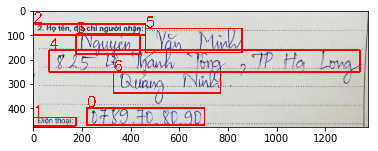

In [76]:
img = draw_boxes(fname, list_box)

In [73]:
save_image('output2.png', img)

### Join boxes

In [74]:
list_box

[(220, 397, 704, 467),
 (0, 436, 176, 470),
 (0, 52, 462, 99),
 (176, 95, 440, 177),
 (66, 159, 1342, 249),
 (462, 71, 858, 170),
 (330, 250, 770, 337)]

In [101]:
def overlap(x0, x1):
    olap = [0] * 2
    
    if x0[0] >= x1[1] or x0[1] <= x1[0]:
        return 0.
    
    olap[0] = max(x0[0], x1[0])
    olap[1] = min(x0[1], x1[1])
    
    print(x0, x1, olap)
    
    return len_x(*olap) * 1. / max(len_x(x0[0], x1[1]), len_x(x0[1], x1[0]))

def overlap_hor(x0, x1):
    olap = min(len_x(x0[1], x1[0]), len_x(x0[0], x1[1]))
    total =  max(len_x(x0[1], x1[0]), len_x(x0[0], x1[1]))
    print(x0, x1, olap, total)
    return olap * 1. / total

def olap_box(box0, box1):
    x0 = [box0[1], box0[3]]
    x1 = [box1[1], box1[3]]
    return overlap(x0, x1)
    

def olap_box_hor(box0, box1):
    x0 = [box0[0], box0[2]]
    x1 = [box1[0], box1[2]]
    return overlap_hor(x0, x1)
    

def join_box(box0, box1):
    return (min(box0[0], box1[0]), min(box0[1], box1[1]), max(box0[2], box1[2]), max(box0[3], box1[3]))

def len_x(a, b):
    return abs(a - b)

def join_all_boxes(list_box):
    boxes = list_box.copy()
    
    # sort by x[1]
    boxes = sorted(boxes, key=lambda x: x[1])
    ret = []
    
    for i in range(len(boxes) - 1):
        if olap_box(boxes[i], boxes[i + 1]) > 0.6:
            if olap_box_hor(boxes[i], boxes[i + 1]) < 0.2:
                ret.append(i)
    
    ret_boxes = []
    # 
    i = 0
    while i < len(boxes):
        if i not in ret:
            ret_boxes.append(boxes[i])
            i += 1
        else:
            bb = join_box(boxes[i], boxes[i + 1])
            ret_boxes.append(bb)
            i += 2
    
    return ret_boxes
        

In [104]:
boxes = join_all_boxes(list_box)

[52, 99] [71, 170] [71, 99]
[71, 170] [95, 177] [95, 170]
[462, 858] [176, 440] 22 682
[95, 177] [159, 249] [159, 177]
[397, 467] [436, 470] [436, 467]


In [107]:
def get_out_name(fname):
    return fname.split('.')[0] + '_out.png'

In [115]:
def boxes_pipeline(fname, line_detector=line_detector):
    print('Detecting boxes...')
    list_box = line_detector.run_file(fname)
    print('Got {} boxes'.format(len(list_box)))
    
    
    boxes = join_all_boxes(list_box)
    print('Reduce to {} boxes.'.format(len(boxes)))
    img = draw_boxes(fname, boxes)
    save_image(get_out_name(fname), img)
    return boxes

[52, 99] [71, 170] [71, 99]
[71, 170] [95, 177] [95, 170]
[462, 858] [176, 440] 22 682
[95, 177] [159, 249] [159, 177]
[397, 467] [436, 470] [436, 467]


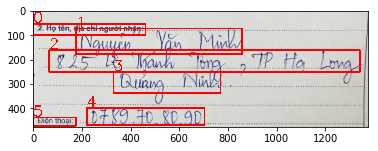

In [111]:
boxes = boxes_pipeline(fname, line_detector)

In [113]:
fname = '000.png'

[258, 375] [264, 347] [264, 347]
[195, 1212] [58, 195] 0 1154
[358, 444] [385, 422] [385, 422]


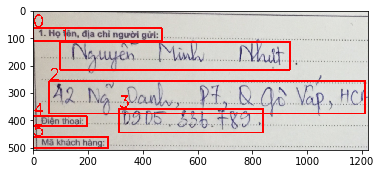

In [114]:
boxes = boxes_pipeline(fname, line_detector)